# Table of Contents
#### 01. Importing
#### 02. Subsetting, wrangling, and cleaning time-series data
#### 03. Time-series analysis: decomposition
#### 04. Testing for stationarity
#### 05. Stationarizing the Federal Reserve Economic Data
#### 06. Exporting

### 01. Importing

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = 'qKSCbnZaczYeG_tPJFz9'

In [5]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/GDP')

In [6]:
data.head()

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [7]:
data.shape

(300, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

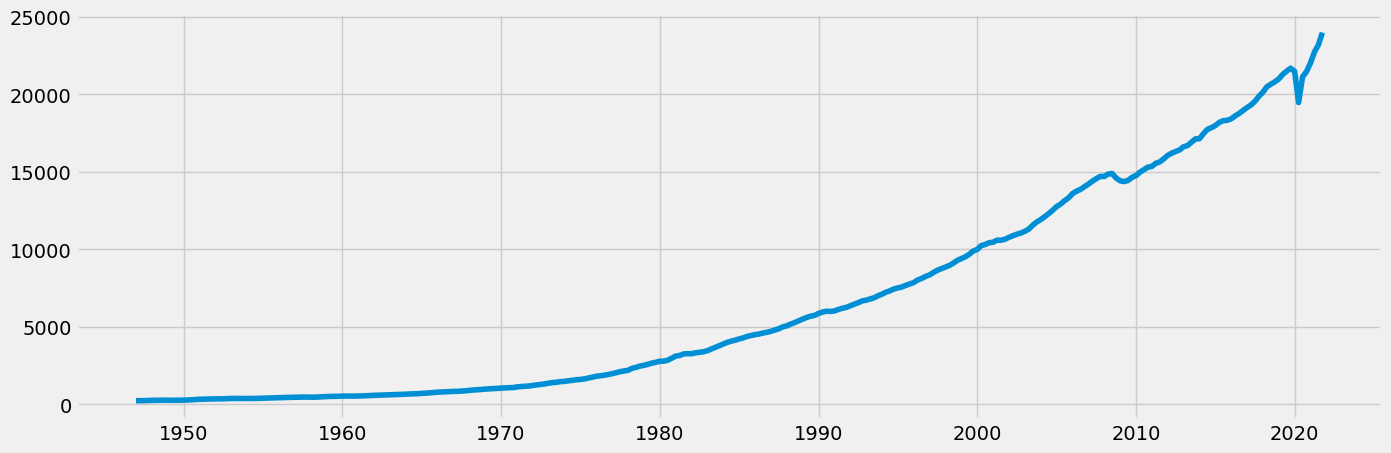

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### 02. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [13]:
data_sub = data_2.loc[(data_2['Date'] >= '2005-01-01') & (data_2['Date'] < '2020-06-01')]

using 2005-2020 as my World Happiness Report data starts in 2005

In [14]:
data_sub.shape

(62, 2)

In [15]:
data_sub.head()

,Date,Value
232,2005-01-01,12767.286
233,2005-04-01,12922.656
234,2005-07-01,13142.642
235,2005-10-01,13324.204
236,2006-01-01,13599.160


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2005-01-01,12767.286
2005-04-01,12922.656
2005-07-01,13142.642
2005-10-01,13324.204
2006-01-01,13599.160


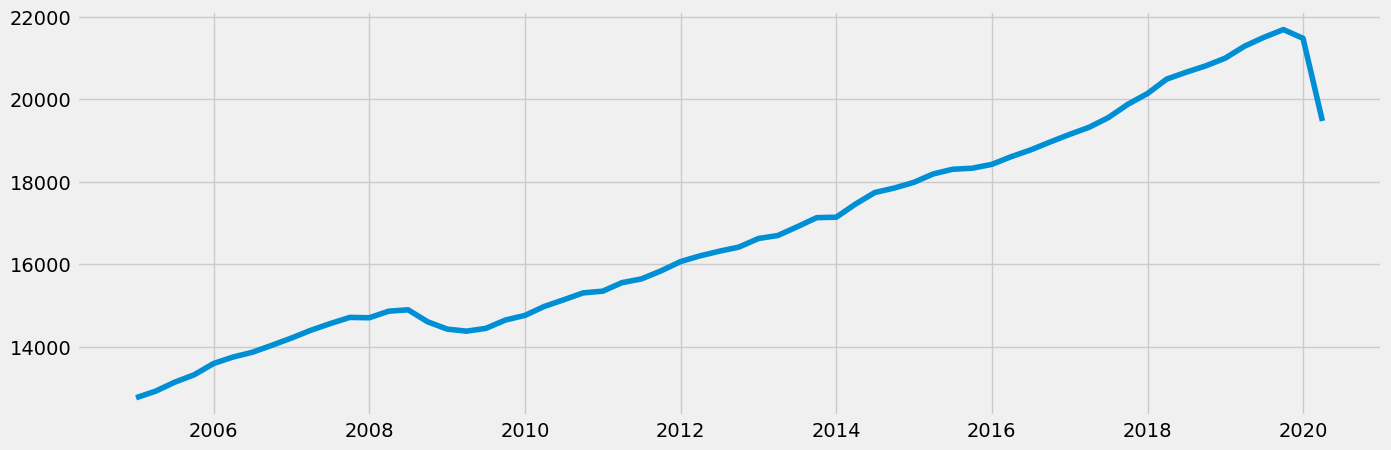

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [19]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

### 03. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

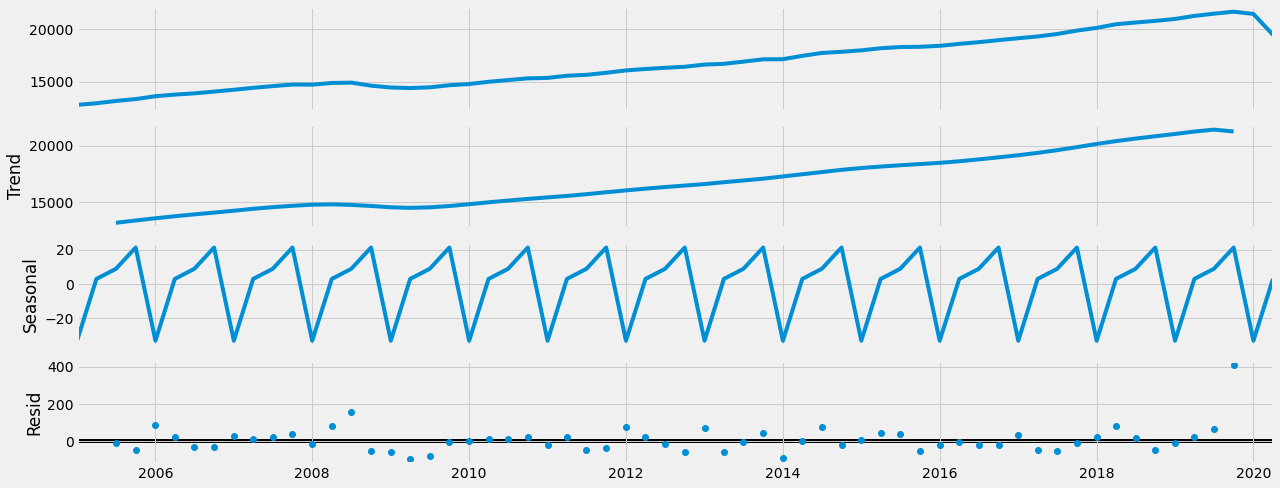

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

### 04. Testing for stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.582010
p-value                         0.096773
Number of Lags Used             1.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


critical value < test statistic - cannot reject null hypothesis therefore data is non stationary

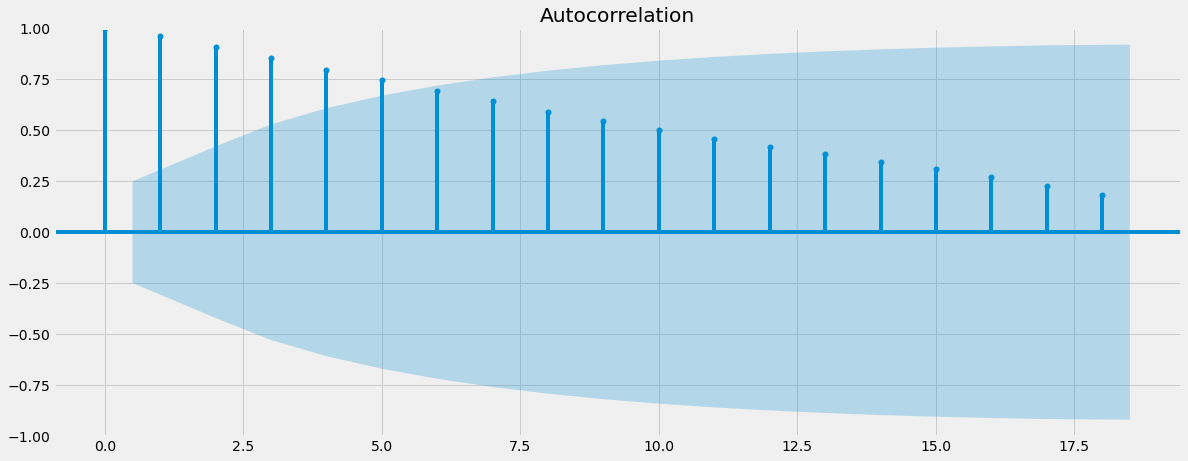

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 05. Stationarizing the Federal Reserve Economic Data

In [25]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True)

In [27]:
data_diff.head()

,Value
datetime,
2005-04-01,155.370
2005-07-01,219.986
2005-10-01,181.562
2006-01-01,274.956
2006-04-01,154.264


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

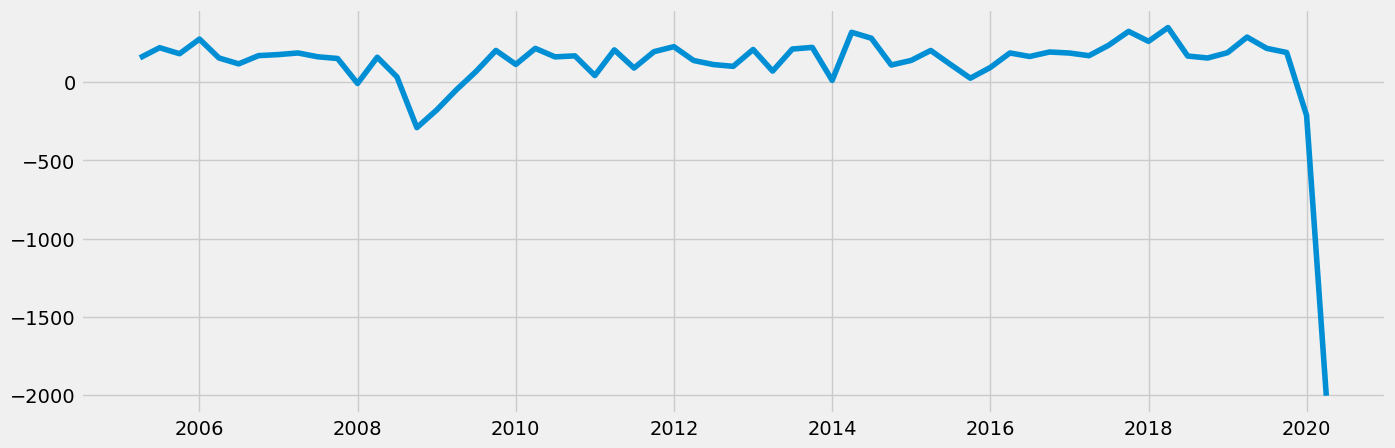

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -0.063388
p-value                         0.952965
Number of Lags Used             1.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


stationarity is worse than previously

In [39]:
data_diff.tail()

,Value
datetime,
2019-04-01,287.677
2019-07-01,215.744
2019-10-01,189.446
2020-01-01,-213.091
2020-04-01,-2003.923


In [40]:
data_diff2=data_diff.drop(['2020-04-01','2020-01-01'])

In [41]:
data_diff2.tail()

,Value
datetime,
2018-10-01,154.223
2019-01-01,188.266
2019-04-01,287.677
2019-07-01,215.744
2019-10-01,189.446


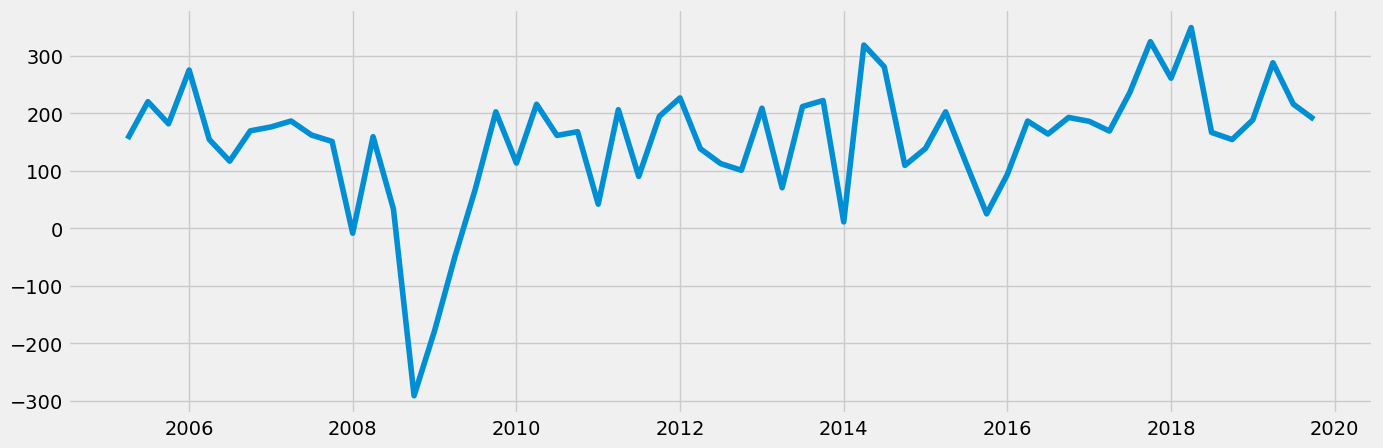

In [42]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [43]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.388986
p-value                         0.000310
Number of Lags Used             0.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


critical value > test statistic - can reject null hypothesis therefore data is stationary<br>
p-value is also less than 0.05

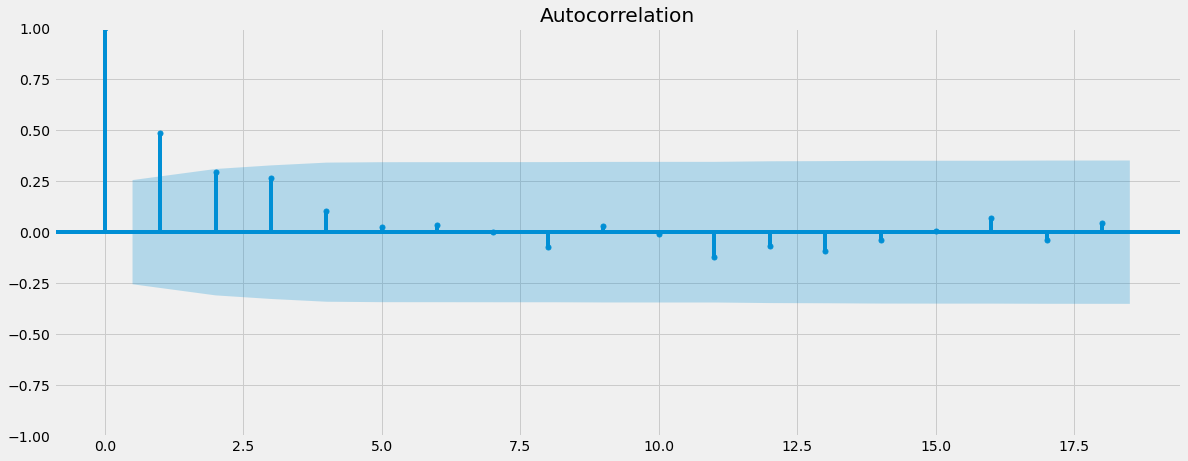

In [44]:
plot_acf(data_diff2)
plt.show()

In [ ]:
#export data
df.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'GDP.pkl'))